In [15]:
import numpy
import json
import requests

Client identification

In [14]:
client_json = json.load(open("client_secret.txt", "r"))
client_secret = client_json["client_secret"]
client_id = client_json["client_id"]

Athlete connection

In [113]:
login_url = f"""http://www.strava.com/oauth/authorize?client_id={client_id}&response_type=code&redirect_uri=http://localhost/exchange_token&approval_prompt=force&scope=activity:read_all"""
print(f"Connect to \n{login_url}")

Connect to 
http://www.strava.com/oauth/authorize?client_id=73454&response_type=code&redirect_uri=http://localhost/exchange_token&approval_prompt=force&scope=activity:read_all


In [114]:
# Insert code from URL here
code = "CODE"

Token exchange

In [115]:
r = requests.post('https://www.strava.com/api/v3/oauth/token', data={'key' : 'value',
                                                                    'client_id' : client_id,
                                                                    'client_secret' : client_secret,
                                                                    'code' : code,
                                                                    'grant_type' : 'authorization_code'})

In [116]:
assert 200 == r.status_code

In [ ]:
response = json.loads(r.text)
response

In [119]:
access_token = response["access_token"]

Cache requests

In [169]:
import os
import hashlib

In [184]:
def hash_hex(query):
    sha = hashlib.sha256()
    sha.update(query.encode())
    return sha.hexdigest()[:10]

In [252]:
def request_cache(query, verbose=False):
    if verbose:print("Query is:", query)
    query_hash = hash_hex(query)
    query_path = os.path.join("query_cache", str(query_hash))
    if verbose:print("Cache path is:", query_path)
    if os.path.exists(query_path):
        if verbose:print("Exists")
        return json.load(open(query_path, "r"))
    else:
        if verbose:print("Does not exist. Querying & saving.")
        r = requests.get(query, headers = {'Content-Type':'application/json',
                                           "Authorization" : f"Bearer {access_token}"})
        
        if r.status_code == 200:
            result = json.loads(r.text)
            json.dump(result, open(query_path, "w"))
            return result
        else:
            print(f"Error with query {query}, returned {r.text}")
            raise ValueError

List all activities

In [188]:
all_activities = []
limit = 10
for i in range(1, limit + 1):
    print(i)
    query = f"https://www.strava.com/api/v3/athlete/activities?page={i}&per_page=30"
    activities_sub = request_cache(query)
    print(len(activities_sub))
    if len(activities_sub) == 0:
        break
        
    all_activities.extend(activities_sub)

1
30
2
30
3
30
4
11
5
0


Cache in all activities

In [258]:
all_activities_fine = []
for activity in all_activities:
    activity_id = activity["id"]
    activity_fine = request_cache(f"https://www.strava.com/api/v3/activities/{activity_id}")
    all_activities_fine.append(activity_fine)

In [259]:
all_activities_fine = [x for x in all_activities_fine if x["type"] == "Run"]

Explore activity

In [224]:
activity_fine = all_activities_fine[0]

In [225]:
activity_fine["start_date_local"]

'2021-09-08T07:46:34Z'

In [226]:
activity_fine["splits_metric"] # average_speed in mps

[{'distance': 1001.3,
  'elapsed_time': 706,
  'elevation_difference': -8.5,
  'moving_time': 527,
  'split': 1,
  'average_speed': 1.9,
  'average_grade_adjusted_speed': 1.88,
  'pace_zone': 0},
 {'distance': 1001.6,
  'elapsed_time': 312,
  'elevation_difference': -0.5,
  'moving_time': 312,
  'split': 2,
  'average_speed': 3.21,
  'average_grade_adjusted_speed': 3.21,
  'pace_zone': 0},
 {'distance': 1000.8,
  'elapsed_time': 289,
  'elevation_difference': 1.0,
  'moving_time': 289,
  'split': 3,
  'average_speed': 3.46,
  'average_grade_adjusted_speed': 3.47,
  'pace_zone': 0},
 {'distance': 996.4,
  'elapsed_time': 286,
  'elevation_difference': 0.0,
  'moving_time': 286,
  'split': 4,
  'average_speed': 3.48,
  'average_grade_adjusted_speed': 3.49,
  'pace_zone': 0},
 {'distance': 1001.5,
  'elapsed_time': 288,
  'elevation_difference': 0.0,
  'moving_time': 288,
  'split': 5,
  'average_speed': 3.48,
  'average_grade_adjusted_speed': 3.48,
  'pace_zone': 0},
 {'distance': 999.5,

Utils

In [261]:
import matplotlib.pyplot as plt

In [262]:
def pace_activity_spkm(activity_fine):
    speed_mps = activity_fine["distance"] / activity_fine["moving_time"]
    pace_spm = 1 / speed_mps
    pace_spkm = pace_spm * 1000
    return pace_spkm
    # get_min_sec_fromseconds(pace_spkm)

In [269]:
def speed_activity_kmh(activity_fine):
    speed_mps = activity_fine["distance"] / activity_fine["moving_time"]
    speed_kmh = speed_mps * 3.6
    return speed_kmh
    # get_min_sec_fromseconds(pace_spkm)

In [263]:
def get_min_sec_fromseconds(seconds):
    mins = int(seconds / 60)
    seconds_remainder = int(seconds % 60)
    return mins, seconds_remainder

Plot perfs

In [270]:
all_paces_spkm = [pace_activity_spkm(x) for x in all_activities_fine]
all_speeds_kmh = [speed_activity_kmh(x) for x in all_activities_fine]
all_paces_minpkm = [pace_activity_spkm(x) / 60 for x in all_activities_fine]
all_distances_km = [x["distance"] / 1e3 for x in all_activities_fine]

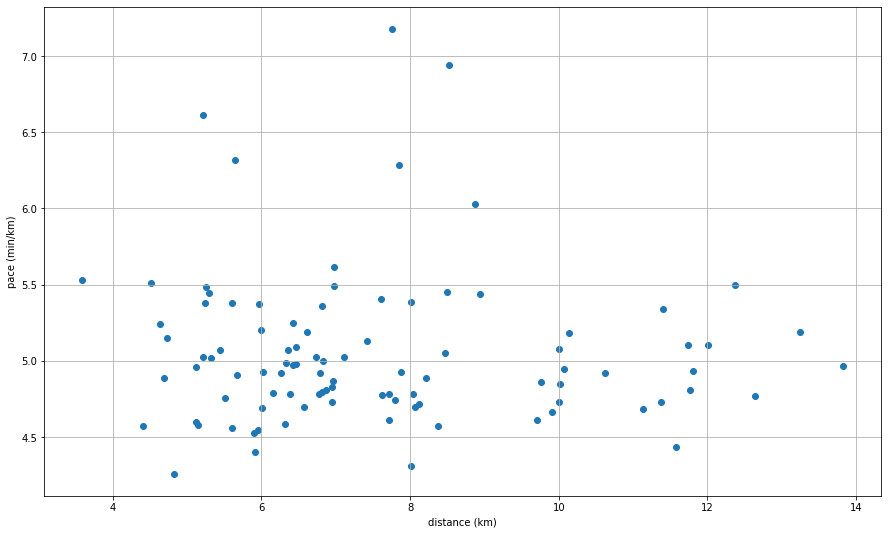

In [268]:
plt.figure(figsize=[15,9])
plt.scatter(all_distances_km, all_paces_minpkm)
plt.ylabel("pace (min/km)")
plt.xlabel("distance (km)")
plt.grid()
plt.show()

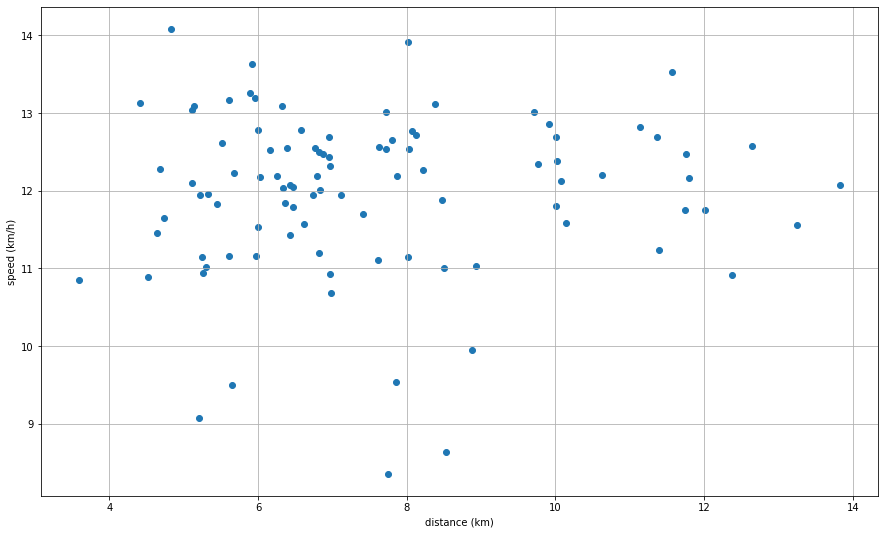

In [271]:
plt.figure(figsize=[15,9])
plt.scatter(all_distances_km, all_speeds_kmh)
plt.ylabel("speed (km/h)")
plt.xlabel("distance (km)")
plt.grid()
plt.show()

Breakdown activities

In [ ]:
def extract_sub_activities(activities_fine):
    all_sub_activities_fine = []
    for activity_fine in activities_fine:
        splits = activity_fine["splits_metric"]
        for splits_slice in iterate_splits(splits):
            distance, moving_time = combine_splits(splits_slice)
            all_sub_activities_fine.append({"distance" : distance,
                                            "moving_time" : moving_time,
                                            "source_id" : activity_fine["id"]})
    return all_sub_activities_fine

In [287]:
def combine_splits(splits_slice):
    distance = sum([x["distance"] for x in splits_slice])
    moving_time = sum([x["moving_time"] for x in splits_slice])
    return distance, moving_time

In [288]:
def iterate_splits(splits):
    for i in range(len(splits)):
        for j in range(i):
            yield splits[j:i]

In [286]:
all_sub_activities_fine = extract_sub_activities(all_activities_fine)

Plot for all sub splits

In [289]:
all_paces_spkm = [pace_activity_spkm(x) for x in all_sub_activities_fine]
all_speeds_kmh = [speed_activity_kmh(x) for x in all_sub_activities_fine]
all_paces_minpkm = [pace_activity_spkm(x) / 60 for x in all_sub_activities_fine]
all_distances_km = [x["distance"] / 1e3 for x in all_sub_activities_fine]

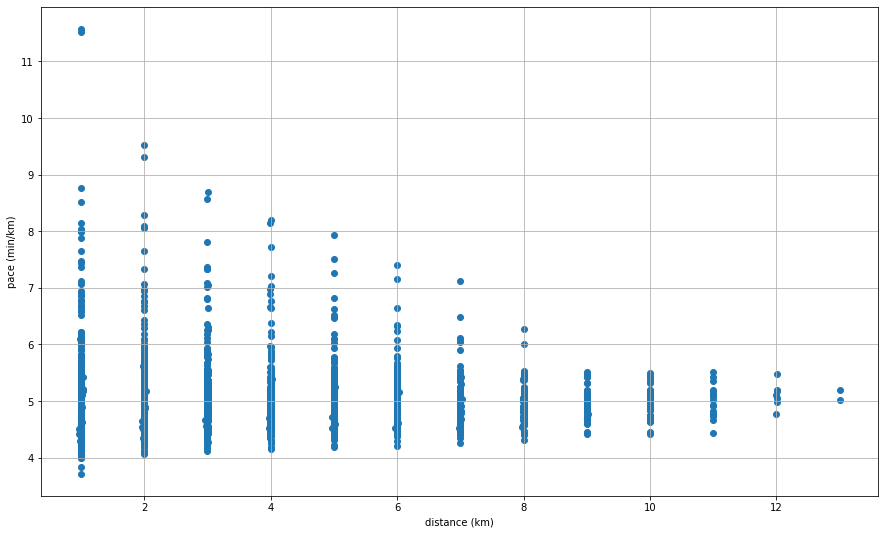

In [293]:
plt.figure(figsize=[15,9])
plt.scatter(all_distances_km, all_paces_minpkm)
plt.ylabel("pace (min/km)")
plt.xlabel("distance (km)")
plt.grid()
plt.show()

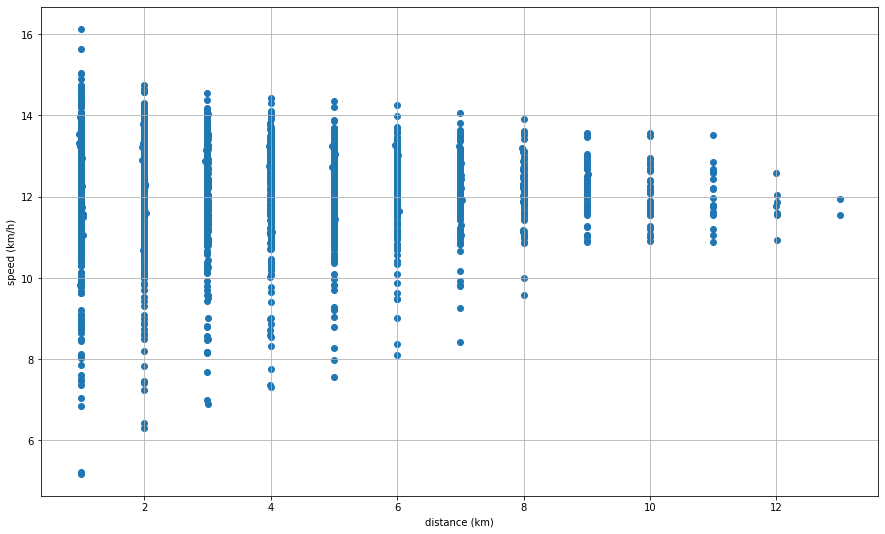

In [294]:
plt.figure(figsize=[15,9])
plt.scatter(all_distances_km, all_speeds_kmh)
plt.ylabel("speed (km/h)")
plt.xlabel("distance (km)")
plt.grid()
plt.show()

Cover curve by slice of runs

In [301]:
import pandas as pd

In [309]:
def extract_cover(sub_activities_fine):
    df = pd.DataFrame(sub_activities_fine)
    df["distance_km_round"] = df.distance // 1e3
    df["speed_mps"] = df["distance"] / df["moving_time"]
    df["speed_kmh"] = df["speed_mps"] * 3.6
    return df.groupby("distance_km_round").speed_kmh.max()

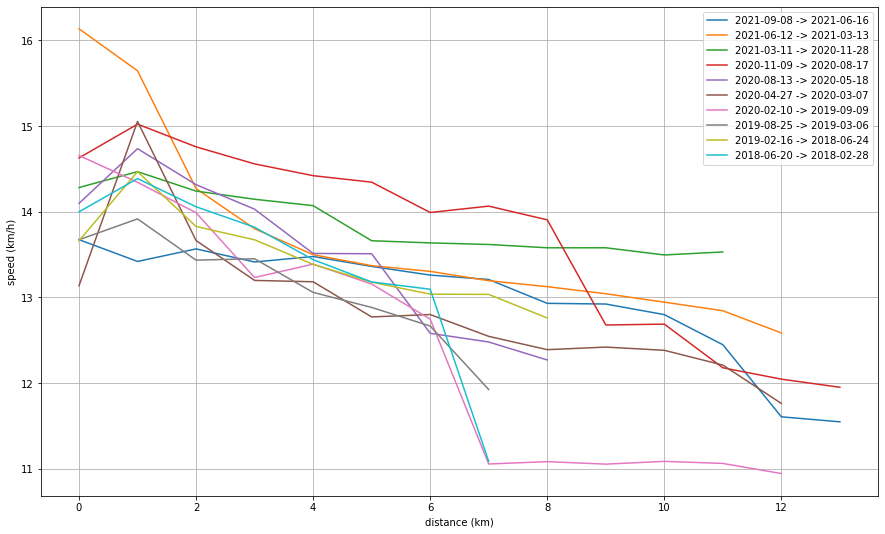

In [317]:
plt.figure(figsize=[15, 9])
for k in range(10):
    sub_activities = all_activities_fine[k*10:(k+1)*10]
    all_sub_activities_fine = extract_sub_activities(sub_activities)
    cover = extract_cover(all_sub_activities_fine)
    
    label = sub_activities[0]["start_date_local"][:10] + " -> " + sub_activities[-1]["start_date_local"][:10]
    plt.plot(cover, label = label)

plt.legend()
plt.ylabel("speed (km/h)")
plt.xlabel("distance (km)")
plt.grid()
plt.show()